In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
import random
import math
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, SimpleRNN, Conv1D, Bidirectional, GRU, Flatten, Activation, BatchNormalization,Input
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from keras.models import load_model
from keras_self_attention import SeqSelfAttention
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, Activation, Bidirectional, Flatten, TimeDistributed, SimpleRNN, Dropout, GRU, Input, Add, Multiply,Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras import optimizers, initializers
from keras.regularizers import l2
from keras.initializers import TruncatedNormal, Constant, RandomNormal
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras import backend as K 
print(tf.__version__)
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)
K.clear_session()
import pandas as pd
from pandas import DataFrame
from sklearn import preprocessing

1.15.0


Using TensorFlow backend.


In [20]:
pys=pd.read_excel("soil yield price 5W.xlsx")
# p is the output price
p=pys.iloc[:,1:2]
# x is the soil moisture and temperature
x=pys.iloc[:,21:]
pys.head()

,Date,Price,Yield,UTC_DATE,T_CALC,T_HR_AVG,T_MAX,T_MIN,P_CALC,SOLARAD,...,SUR_TEMP_MAX,SUR_TEMP_MIN,RH_HR_AVG,PDSI,Palmer Z-index,SPI,SPEI,Self-calibrated PDSI,Soil Moisture,Soil Temperature
0,2011-10-22,1.212425,106.648998,2011-04-30,16.683333,16.829167,24.3,7.5,0.000000,329.500000,...,29.7,5.5,33.541667,3.61,-1.43,-0.97,-0.81,1.94,0.195538,23.029219
1,2011-10-23,1.211449,101.277216,2011-05-01,16.141667,15.075000,21.3,7.6,0.016667,331.625000,...,30.6,5.7,55.875000,3.63,1.15,1.08,1.02,2.04,0.191317,22.941509
2,2011-10-24,1.030000,125.000000,2011-05-02,15.600000,15.708333,21.7,7.6,0.016667,332.083333,...,31.1,5.5,56.500000,3.63,1.15,1.08,1.02,2.04,0.187171,23.314857
3,2011-10-25,1.000000,143.000000,2011-05-03,16.270833,16.083333,22.3,9.4,0.000000,325.500000,...,32.5,7.5,66.875000,3.63,1.15,1.08,1.02,2.04,0.183454,23.823008
4,2011-10-26,1.000000,106.000000,2011-05-04,16.608333,16.595833,24.3,10.1,0.000000,323.500000,...,33.8,8.3,74.083333,3.63,1.15,1.08,1.02,2.04,0.179729,24.544578


Text(0.5, 1.0, 'Price')

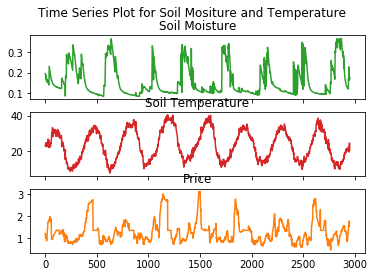

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
fig.suptitle('Time Series Plot for Soil Mositure and Temperature')
ax1.plot(pys["Soil Moisture"],'tab:green')
ax1.set_title('Soil Moisture')
ax2.plot(pys["Soil Temperature"],'tab:red')
ax2.set_title('Soil Temperature')
ax3.plot(pys["Price"],'tab:orange')
ax3.set_title("Price")

# Smoothing the price values

In [22]:

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline



fit1 = ExponentialSmoothing(p, seasonal_periods=12, seasonal='multiplicative').fit()
y=fit1.fittedvalues

/home/mohita/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [23]:
#set random seed for reproducibility
print(tf.__version__)
import os
import random
os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# Creating the data with lag
data=x.values
print(data.shape)
data = series_to_supervised(data, 139)

# Normalizing the dataset
scaler = preprocessing.StandardScaler().fit(data)
scaler
d= scaler.transform(data)

1.15.0
(2951, 1)


In [24]:
#function to find the value of d for POV=95%
def Proportion_of_Variance(x):
    val,vec=np.linalg.eig(np.cov(x.T))
    indexes=np.argsort(np.abs(val))[::-1]
    val_sorted=val[indexes]
    val_sum=val_sorted.sum()
    for k in range(784):
        k_val_sum=val_sorted[:k+1].sum()
        POV=k_val_sum/val_sum
        if POV >= 0.96:
            break
    return(k+1)
#Function to reconstruct the compressed data

k=Proportion_of_Variance(d)
print('\n The value of d using POV = 95% is ',k)


 The value of d using POV = 95% is  2


In [25]:
from sklearn.decomposition import PCA

my_model = PCA(n_components=2)
d=my_model.fit_transform(d)

In [26]:
X=d
Y=y
Y=Y[:2812].values

print(X.shape)
print(Y.shape)
    
x_train = X[0:int(0.8*X.shape[0])]
x_test = X[int(0.8*X.shape[0]):]
y_train = Y[0:int(0.8*Y.shape[0])]
y_test = Y[int(0.8*Y.shape[0]):]
print(x_test.shape)
print(y_test.shape)
#np.random.shuffle(x_train)
print(x_train.shape)
print(y_train.shape)

(2812, 2)
(2812,)
(563, 2)
(563,)
(2249, 2)
(2249,)


# Att-CNN-LSTM

In [27]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)



keras.backend.clear_session()

os.environ['PYTHONHASHSEED'] = '42'
np.random.seed(42)
tf.random.set_random_seed(seed=42)
np.random.RandomState(42)
random.seed(42)

model_lime_cnn_lstm_att = keras.models.Sequential([
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu",
                          input_shape=(2, 1)),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      keras.layers.Conv1D(filters=120, kernel_size=3,
                          strides=1, padding="causal",
                          activation="relu"),
      keras.layers.LSTM(100, return_sequences=True, activation='relu'),
      keras.layers.LSTM(100, return_sequences=True, activation='relu'),
      SeqSelfAttention(attention_activation='sigmoid'),
      keras.layers.Flatten(),
      keras.layers.Dense(64, activation="relu"),
      keras.layers.Dense(32, activation="relu"),
      keras.layers.Dense(16, activation="relu"),
      keras.layers.Dense(1),
      keras.layers.Lambda(lambda x: x * 400)
])


optimizer = keras.optimizers.Adam(lr=1e-4)
model_lime_cnn_lstm_att.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=["mae"])

#Create Model Checkpoints
filepath_lime_cnn_lstm_att = "weights_lime_cnn_lstm_att_5P_soil.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath_lime_cnn_lstm_att,
                                 monitor = 'val_loss',
                                 verbose = 0,
                                 save_best_only = True,
                                 mode = 'min')

history_lime_cnn_lstm_att = model_lime_cnn_lstm_att.fit(x_train, y_train,  validation_data= (x_test, y_test),epochs=200, callbacks = [checkpoint],verbose=0)
    

R2 Score:  0.541108560022186  , MAE:  0.28406913026741415  , RMSE:  0.35164775749224214  , Agg:  0.14586251902112152


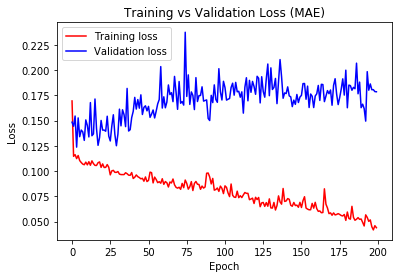

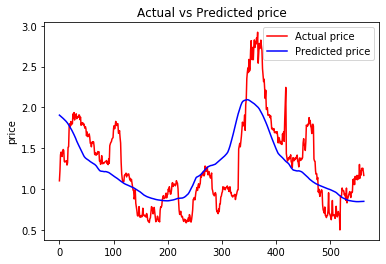

In [28]:
#Load best weights
model_lime_cnn_lstm_att.load_weights(filepath_lime_cnn_lstm_att)
    
plt.figure()
plt.plot(np.arange(len(history_lime_cnn_lstm_att.history['loss'])), history_lime_cnn_lstm_att.history['loss'], color='r', label='Training loss')
plt.plot(np.arange(len(history_lime_cnn_lstm_att.history['loss'])), history_lime_cnn_lstm_att.history['val_loss'], color='b', label='Validation loss')
plt.title('Training vs Validation Loss (MAE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
    
y_pred = model_lime_cnn_lstm_att.predict(x_test)
y_pred_1x = y_pred
    
plt.figure()
plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual price')
plt.plot(np.arange(len(y_test)), y_pred, color='b', label='Predicted price')
plt.title('Actual vs Predicted price')
plt.ylabel('price')
plt.legend()



r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

print('R2 Score: ', r2, ' , MAE: ', mae, ' , RMSE: ',np.sqrt(mse), ' , Agg: ', agg_err)

# Att-SeriesNet-GRU

In [29]:
def DCCNN_Block(n_filters, filter_width, dilation_rate, l2reg,input1):
    residual = input1
    layer_1 = Conv1D(filters=n_filters, kernel_size=filter_width, dilation_rate=dilation_rate, 
                    activation='linear', padding='causal', use_bias=False, 
                    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10), 
                    kernel_regularizer=l2(l2reg))(input1)    
    layer_1 = Activation('selu')(layer_1)
    skip = Conv1D(1,1, activation='linear', use_bias=False, 
                  kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                  kernel_regularizer=l2(l2reg))(layer_1)
    layer_2 = Conv1D(1,1, activation='linear', use_bias=False, 
                     kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),
                     kernel_regularizer=l2(l2reg))(layer_1)  
    To_Next_Layer = Add()([residual, layer_2])
    return To_Next_Layer, skip


def Model_Build_SN_GRU(length):

    input1 = Input(shape=(length,1))

    input2 = Input(shape=(length,1))

    n_filters = 32

    filter_width = 2

    dilation_rates = [2**i for i in range(7)] #for 7 layers.

    l2reg = 0.01

    l1a, l1b = DCCNN_Block(n_filters,filter_width,dilation_rates[0],l2reg,input1) 

    l2a, l2b = DCCNN_Block(n_filters,filter_width,dilation_rates[1],l2reg,l1a) 

    l3a, l3b = DCCNN_Block(n_filters,filter_width,dilation_rates[2],l2reg,l2a)

    l4a, l4b = DCCNN_Block(n_filters,filter_width,dilation_rates[3],l2reg,l3a)

    l5a, l5b = DCCNN_Block(n_filters,filter_width,dilation_rates[4],l2reg,l4a)

    l6a, l6b = DCCNN_Block(n_filters,filter_width,dilation_rates[5],l2reg,l5a)

    l6b = Dropout(0.8)(l6b)

    l7a, l7b = DCCNN_Block(n_filters,filter_width,dilation_rates[6],l2reg,l6a)

    l7b = Dropout(0.8)(l7b) 

    l8 = Add()([l1b, l2b, l3b, l4b, l5b, l6b, l7b])

    l9 = Activation('relu')(l8)

    l10 = Conv1D(1,1, activation='linear', use_bias=False, 

    kernel_initializer=TruncatedNormal(mean=0.0, stddev=0.05, seed=10),

    kernel_regularizer=l2(0.001))(l9)

    l10a = SeqSelfAttention()(l10)

    l11 = Flatten()(l10a)

    l12 = Dense(1)(l11)




    #######################################################

    #SECOND NETWORK#

    ls2 = GRU(200,return_sequences=True)(input2)

    ls3=SeqSelfAttention()(ls2)

    ls4 = GRU(200,return_sequences=True)(ls3)

    ls4a = Dropout(0.6)(ls4) #initially was 0.6

    ls4b= GRU(200)(ls4a)

    ls5 = Dense(1)(ls4b)

    #######################################################




    l13 = keras.layers.Concatenate()([l12,ls5])

    output= Dense(1,activation='relu')(l13)

    model = Model(input=[input1,input2], output=output)

    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.0, amsgrad=True)

    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae', 'mse'])

    return model

In [30]:
seriesnet = Model_Build_SN_GRU(2)

(2249, 2, 1)
(563, 2, 1)
x_train.shape (2249, 2, 1)
x_test.shape (563, 2, 1)
y_train.shape (2249, 1)
y_test.shape (563, 1)


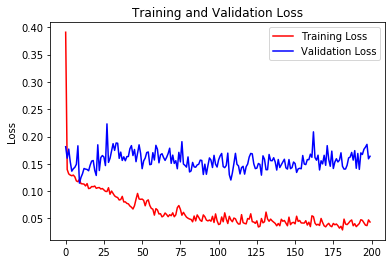

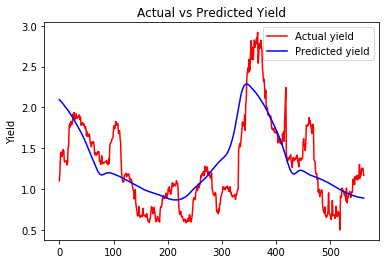

In [31]:

            y_pred_1 = []
            y_tests =[]
            mae_1 = []
            mse_1 = []
            r2_1 = []
            agg_err_1 = []

            filepath_seriesnet = "imputation ahead soil.hdf5"
            checkpoint = keras.callbacks.ModelCheckpoint(filepath_seriesnet,
                                    monitor = 'val_loss',
                                    verbose = 0,
                                    save_best_only = True,
                                    mode = 'min')


            print(x_train.shape)
            print(x_test.shape)

            x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
            x_test = x_test.reshape(x_test.shape[0], x_test.shape[1],1)
            y_train=y_train.reshape(-1,1)
            y_test=y_test.reshape(-1,1)

            print('x_train.shape',x_train.shape)
            print('x_test.shape',x_test.shape)
            print('y_train.shape',y_train.shape)
            print('y_test.shape',y_test.shape)



            os.environ['PYTHONHASHSEED'] = '42'
            np.random.seed(42)
            tf.random.set_random_seed(seed=42)
            np.random.RandomState(42)
            random.seed(42)


            history=seriesnet.fit([x_train,x_train],
                            y_train,  epochs=200,validation_data=([x_test,x_test],y_test),
                            callbacks=[checkpoint],verbose=0 )

            #Load best weights
            seriesnet.load_weights(filepath_seriesnet)


            y_test=y_test.reshape(-1,1)
            y_pred = seriesnet.predict([x_test,x_test])
            y_pred=y_pred.reshape(-1,1)
            y_pred_1.append(y_pred)

            plt.figure()
            plt.plot(history.history['loss'],'r',label='Training Loss')
            plt.plot(history.history['val_loss'],'b',label='Validation Loss')
            plt.title('Training and Validation Loss')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(np.arange(len(y_test)), y_test, color='r', label='Actual price')
            plt.plot(np.arange(len(y_test)), y_pred, color='b', label='Predicted price')
            plt.title('Actual vs Predicted price')
            plt.ylabel('price')
            plt.legend()
            plt.show()



            


In [32]:
seriesnet.load_weights(filepath_seriesnet)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
agg_err = ((np.sqrt(mse) + mae)/2) * (1-r2)

m = 365
num = np.mean(np.abs(y_test - y_pred))
den = np.sum(np.abs(y_train[m + 1:] - y_train[:-(m + 1)])) / (len(y_train) - m)


print('R2 Score: ', r2, ' , MAE: ', mae, ' , MSE: ',mse, ' , Agg: ', agg_err, 'MASE:', num/den)

R2 Score:  0.5747284666785277  , MAE:  0.26462100691557106  , MSE:  0.1145966866147509  , Agg:  0.12824963188074345 MASE: 0.7797674846232425
